### Objective:
The objetive of this project is to build a recommendation system for products on an e-commerce website. The data set being used for this project is sourced from (http://jmcauley.ucsd.edu/data/amazon/). From the website we have information that the data included in the dataset has user_id,item_code,rating and timestamp. There is no other meta data or specific reviews available. In this project we are going to build recommendation model for the electronics products based on the available data.

### Import Required Libraries

In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Data Import

Let's now import the data and identify the charecteristics of the data and also organize the data for further exploration.

In [218]:
products_df = pd.read_csv('ratings_Electronics.csv')
products_df.tail()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200
7824480,A2G81TMIOIDEQQ,BT008V9J9U,5.0,1312675200


In [219]:
#Defining column headers
products_df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

#The timestamp is not of any relevance for the recommeder system at this point of time.
#We will drop that column
products_df.drop('timestamp', axis=1,inplace=True)


In [220]:
rows, columns = products_df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824481
No of columns:  3


In [221]:
products_df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [222]:
print('Number of missing values across columns-\n', products_df.isnull().sum())


Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


In [223]:
products_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rating,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


There are no missing values with total records 7824482. Rating is the only column which is integer type. The min and max value of this column as in the description above is 1 and 5. 

### Ratings are on scale of 1 - 5

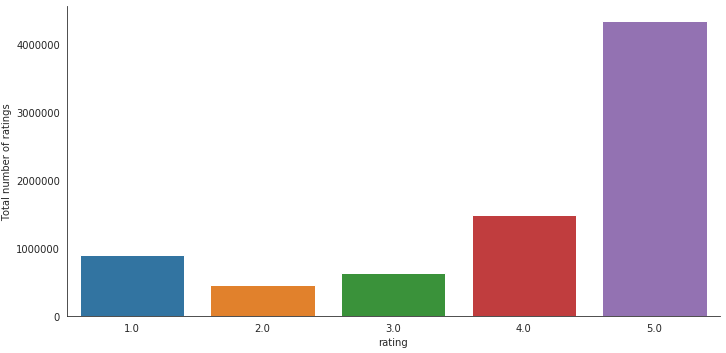

In [224]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=products_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

In [225]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', products_df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', products_df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476001


#### Making the dataset sparse
Since the dataset is too dense, we will take a subset of the data. We will only consider the users who have given more than 30 ratings of 3,4 or 5 stars. 

In [226]:
main_customers = products_df.user_id.value_counts()
main_customers = main_customers[main_customers >= 50]

products_df_sparse = products_df[products_df['user_id'].isin(main_customers.index)]
#products_df_sparse = products_df_sparse[products_df_sparse['rating']>=4]


In [227]:
print('Number of users who have rated 30 or more items >= 4 is ', len(products_df_sparse))
print('Number of unique USERS in final data is ', products_df_sparse['user_id'].nunique())
print('Number of unique ITEMS in final data is ', products_df_sparse['prod_id'].nunique())

Number of users who have rated 30 or more items >= 4 is  125871
Number of unique USERS in final data is  1540
Number of unique ITEMS in final data is  48190


In [228]:
products_df_sparse.tail(10)

,user_id,prod_id,rating
7824413,A2XX2A4OJCDNLZ,B00LED02VY,4.0
7824421,AEIB3UR05OP7A,B00LGN7Y3G,5.0
7824422,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824423,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824424,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824435,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824437,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0
7824443,A2BYV7S1QP2YIG,B00LKG1MC8,5.0


#### Calculate the density of the rating matrix

In [229]:
final_ratings_matrix = pd.pivot_table(products_df_sparse,index=["user_id"],columns=["prod_id"],values=["rating"]).fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


In [230]:
final_ratings_matrix.tail()

rating                                              \
prod_id       0594451647 0594481813 0970407998 0972683275 1400501466   
user_id                                                                
AZBXKUH4AIW3X        0.0        0.0        0.0        0.0        0.0   
AZCE11PSTCH1L        0.0        0.0        0.0        0.0        0.0   
AZMY6E8B52L2T        0.0        0.0        0.0        0.0        0.0   
AZNUHQSHZHSUE        0.0        0.0        0.0        0.0        0.0   
AZOK5STV85FBJ        0.0        0.0        0.0        0.0        0.0   

                                                                      ...  \
prod_id       1400501520 1400501776 1400532620 1400532655 140053271X  ...   
user_id                                                               ...   
AZBXKUH4AIW3X        0.0        0.0        0.0        0.0        0.0  ...   
AZCE11PSTCH1L        0.0        0.0        0.0        0.0        0.0  ...   
AZMY6E8B52L2T        0.0        0.0        0.0        0.0        0.0  ...   
AZNUHQSHZHSUE        0.0        0.0        0.0        0.0        0.0  ...   
AZOK5STV85FBJ        0.0        0.0        0.0        0.0        0.0  ...   

                                                                      \
prod_id       B00L5YZCCG B00L8I6SFY B00L8QCVL6 B00LA6T0LS B00LBZ1Z7K   
user_id                                                                
AZBXKUH4AIW3X        0.0        0.0        0.0        0.0        0.0   
AZCE11PSTCH1L        0.0        0.0        0.0        0.0        0.0   
AZMY6E8B52L2T        0.0        0.0        0.0        0.0        0.0   
AZNUHQSHZHSUE        0.0        0.0        0.0        0.0        0.0   
AZOK5STV85FBJ        0.0        0.0        0.0        0.0        0.0   

                                                                      
prod_id       B00LED02VY B00LGN7Y3G B00LGQ6HL8 B00LI4ZZO8 B00LKG1MC8  
user_id                                                               
AZBXKUH4AIW3X        0.0        0.0        0.0        0.0        0.0  
AZCE11PSTCH1L        0.0        0.0        0.0        0.0        0.0  
AZMY6E8B52L2T        0.0        0.0        0.0        0.0        0.0  
AZNUHQSHZHSUE        0.0        0.0        0.0        0.0        0.0  
AZOK5STV85FBJ        0.0        0.0        0.0        0.0        0.0  

[5 rows x 48190 columns]

### Splitting the data to train the model
We will use the dataset products_df_sparse which we created as a subset of the main data, which contains the data of users who have atleast rated 50 products.

In [231]:
train_data, test_data = train_test_split(products_df_sparse, test_size = 0.3, random_state=5)

With the data available, let's build a Popularity Recommender model. Popularity recommender model as the name suggests is based on the product which has the most recommendation. 

In [232]:
train_data_grouped = train_data.groupby('prod_id').agg({'user_id': 'count'}).reset_index()
train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
print("The minimum number of ratings for products is ",train_data_grouped['score'].min())
print("The maximum number of ratings for product is ", train_data_grouped['score'].max())

The minimum number of ratings for products is  1
The maximum number of ratings for product is  141


In [233]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'prod_id'], ascending = [0,1]) 
      
train_data_sort.index = range(1,len(train_data_sort)+1)
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,prod_id,score
1,B0088CJT4U,141
2,B003ES5ZUU,130
3,B000N99BBC,118
4,B007WTAJTO,117
5,B00829TIEK,105


The popularity based recommendation, will be the same for all users as it is not user specific but rather popularity specific. It is based on how many users have rated it and in the case of our data subset, rate 4 and 5 only. 

### Collaborative Filtering model

#### Model-based Collaborative Filtering: Singular Value Decomposition

In [234]:
pdt_collab_df = pd.concat([train_data, test_data]).reset_index()
pdt_collab_df.head()

,index,user_id,prod_id,rating
0,5815695,A197T2N6RU7K56,B007N6OED8,5.0
1,412739,A3HR0ZZOFKQ97N,B0001Y7UAI,5.0
2,444339,AGHZXQL9F94T9,B0002A6YVC,2.0
3,3481711,A2XJMQ2COPGWJH,B003NSBF32,2.0
4,4580021,A2D1LPEUCTNT8X,B004YKKT26,4.0


In [235]:
#User-based Collaborative Filtering
pivot_df = pd.pivot_table(pdt_collab_df,index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(1540, 48190)


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### SVD method
#### SVD is best to apply on a large sparse matrix

In [236]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(pivot_df, k = 50)
sigma = np.diag(sigma)

In [237]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns, index=pivot_df.index).fillna(0)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
A100WO06OQR8BQ,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
A105S56ODHGJEK,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
A105TOJ6LTVMBG,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
A10AFVU66A79Y1,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [238]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.loc[userID].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userID].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    return(temp.head(num_recommendations))

In [239]:
# Enter 'userID' and 'num_recommendations' for the user #
userids = pivot_df.index
userID = userids[120]
num_recommendations = 5
print(recommend_items(userID, pivot_df, preds_df, num_recommendations))


Below are the recommended items for user(user_id = A19X4BF861LQST):

                   user_ratings  user_predictions
Recommended Items                                
B000LRMS66                  0.0          0.543927
B002WE4HE2                  0.0          0.423175
B000KO0GY6                  0.0          0.416801
B001XURP7W                  0.0          0.356788
B005HMKKH4                  0.0          0.352138


#### Evaluation of Model-based Collaborative Filtering (SVD)

In [240]:
# Actual ratings given by the users
final_ratings_matrix.head()

rating                                              \
prod_id        0594451647 0594481813 0970407998 0972683275 1400501466   
user_id                                                                 
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0   
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0   

                                                                       ...  \
prod_id        1400501520 1400501776 1400532620 1400532655 140053271X  ...   
user_id                                                                ...   
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  ...   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0  ...   
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0  ...   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  ...   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  ...   

                                                                       \
prod_id        B00L5YZCCG B00L8I6SFY B00L8QCVL6 B00LA6T0LS B00LBZ1Z7K   
user_id                                                                 
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0   
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0   
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0   
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0   
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0   

                                                                       
prod_id        B00LED02VY B00LGN7Y3G B00LGQ6HL8 B00LI4ZZO8 B00LKG1MC8  
user_id                                                                
A100UD67AHFODS        0.0        0.0        0.0        0.0        0.0  
A100WO06OQR8BQ        0.0        0.0        0.0        0.0        0.0  
A105S56ODHGJEK        0.0        0.0        0.0        0.0        0.0  
A105TOJ6LTVMBG        0.0        0.0        0.0        0.0        0.0  
A10AFVU66A79Y1        0.0        0.0        0.0        0.0        0.0  

[5 rows x 48190 columns]

In [241]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

        prod_id   
rating  0594451647    0.003247
        0594481813    0.001948
        0970407998    0.003247
        0972683275    0.012338
        1400501466    0.012987
dtype: float64

In [242]:
# Predicted ratings 
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
A100WO06OQR8BQ,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
A105S56ODHGJEK,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
A105TOJ6LTVMBG,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
A10AFVU66A79Y1,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [243]:
# Average PREDICTED rating for each item
preds_df.mean().head()

prod_id
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
dtype: float64

In [244]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(96380, 2)


Avg_actual_ratings  Avg_predicted_ratings  item_index
rating 0594451647            0.003247                    NaN           0
       0594481813            0.001948                    NaN           1
       0970407998            0.003247                    NaN           2
       0972683275            0.012338                    NaN           3
       1400501466            0.012987                    NaN           4

In [245]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = nan 



### Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [246]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = userids[200]
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = A1H98YV5K5BUX0):



,user_ratings,user_predictions
Recommended Items,,
B000QUUFRW,0.0,0.690106
B000N99BBC,0.0,0.680706
B00007E7JU,0.0,0.665840
B00017LSPI,0.0,0.629542
B00004ZCJE,0.0,0.602450


In [247]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf, accuracy
from surprise.model_selection import cross_validate

from surprise.model_selection.split import train_test_split

reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(products_df_sparse[['user_id', 'prod_id', 'rating']], reader)

train_data_svd, test_data_svd = train_test_split(data, test_size = 0.3, random_state=5)
trainset = data.build_full_trainset()
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9824  0.9845  0.9847  0.9800  0.9827  0.9829  0.0017  
MAE (testset)     0.7258  0.7274  0.7272  0.7249  0.7275  0.7266  0.0010  
Fit time          6.38    6.18    5.31    5.32    5.59    5.76    0.45    
Test time         0.35    0.29    0.15    0.16    0.18    0.23    0.08    


{'test_rmse': array([0.98241877, 0.98450835, 0.98474666, 0.98000099, 0.98270905]),
 'test_mae': array([0.7257844 , 0.72744679, 0.72718944, 0.72492867, 0.7275163 ]),
 'fit_time': (6.384947061538696,
  6.181229114532471,
  5.312890291213989,
  5.320284843444824,
  5.588809967041016),
 'test_time': (0.3478107452392578,
  0.29342222213745117,
  0.1519320011138916,
  0.15671586990356445,
  0.1802518367767334)}

In [248]:
predictions = algo.fit(train_data_svd).test(test_data_svd)
accuracy.rmse(predictions)

RMSE: 0.9832


0.983198647113116

In [249]:
from collections import defaultdict


def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(predictions, n=5)


def get_top5_for_user(userId):
    print("Top 5 recommendations for ",userId)
    for reco in top_n[userId]:
        print(reco[0]," - ",reco[1])

In [250]:
get_top5_for_user(userids[200])
get_top5_for_user(userids[120])


Top 5 recommendations for  A1H98YV5K5BUX0
B0000BZL5A  -  5
B004X355Y6  -  4.729542761383751
B00007E7RF  -  4.638391181092508
B00009R6N0  -  4.6260502395533205
B00009R88X  -  4.511373222448344
Top 5 recommendations for  A19X4BF861LQST
B004FLJVXM  -  4.028885237186147
B00009R6JT  -  4.007875951153641
B00009R86Q  -  3.9742954143976865
B000OSZA44  -  3.9545908447673668
B005IHAIDO  -  3.937561875547554


With the surprise.SVD model prediction, Recommendations for user A1H98YV5K5BUX0 are 
B0000BZL5A  -  5
B004X355Y6  -  4.804005296357338
B00007E7RF  -  4.683309636636745
B003DC8D8I  -  4.6606211396136255
B00009R6N0  -  4.581152505805392

Where as using the svd
B000QUUFRW	0.0	0.690106
B000N99BBC	0.0	0.680706
B00007E7JU	0.0	0.665840
B00017LSPI	0.0	0.629542
B00004ZCJE	0.0	0.602450



In [251]:
#get top n recommendations based on items. default 10
def get_top_n_items(predictions, n=10):
    top_n_items = []
    item_count_dictionary = {}
    for uid, iid, true_r, est, _ in predictions:
        top_n_items.append(iid)

    for eachItem in top_n_items:
        if eachItem not in item_count_dictionary:
            ctr = top_n_items.count(eachItem)
            item_count_dictionary.update({eachItem:ctr})
    dict_to_return = sorted(item_count_dictionary.items(), key = 
             lambda kv:(kv[1], kv[0]), reverse = True)
    return dict_to_return[0:n+1]

top_n_items = get_top_n_items(predictions, n=5)

print("The top 5 items recommended")
for item in top_n_items:
    print(item[0])

The top 5 items recommended
B0088CJT4U
B007WTAJTO
B003ES5ZUU
B000N99BBC
B008DWCRQW
B00829TIEK


### Insights

Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.You can see the differance above for the user id 121 & 200, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history